# Classification of emotions

## Importing the libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab.patches import cv2_imshow
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization

## Loading the images

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/Classification of Emotion/fer_images.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

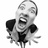

In [4]:
tf.keras.preprocessing.image.load_img('/content/fer2013/train/Angry/1003.jpg')

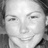

In [5]:
image = tf.keras.preprocessing.image.load_img('/content/fer2013/train/Happy/1.jpg')
image

### Train and test set

In [6]:
training_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2)
train_dataset = training_generator.flow_from_directory('/content/fer2013/train',
                                                        target_size = (48, 48),
                                                        batch_size = 16,
                                                        class_mode = 'categorical',
                                                        shuffle = True)

Found 28709 images belonging to 7 classes.


In [7]:
train_dataset.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [8]:
np.unique(train_dataset.classes, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([3995,  436, 4097, 7215, 4965, 4830, 3171]))

In [9]:
train_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

<ipython-input-10-b65b620cbff3>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = train_dataset.classes, palette='Set2');


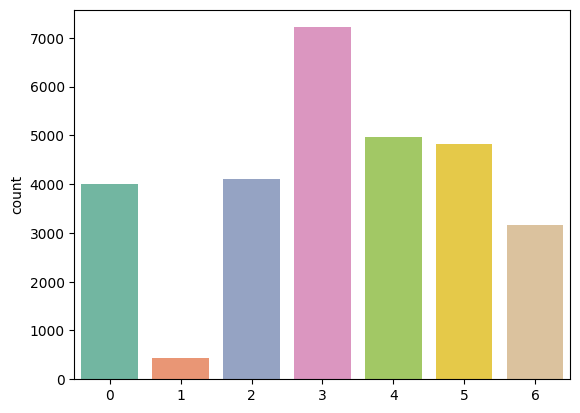

In [10]:
sns.countplot(x = train_dataset.classes, palette='Set2');

In [11]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('/content/fer2013/validation',
                                                  target_size = (48, 48),
                                                  batch_size = 1,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 3589 images belonging to 7 classes.


## Building and training the convolutional neural network

In [12]:
2*2*2*32

256

In [13]:
# Based on: https://github.com/rajeevratan84/DeepLearningCV/blob/master/18.2%20Building%20an%20Emotion%20Detector%20with%20LittleVGG.ipynb
# Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow
# BatchNormalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
# Dropout: https://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf
num_detectors = 32
num_classes = 7
width, height = 48, 48
epochs = 70

CNN = Sequential()

CNN.add(Conv2D(num_detectors, (3,3), activation='relu', padding = 'same', input_shape = (width, height, 3)))
CNN.add(BatchNormalization())
CNN.add(Conv2D(num_detectors, (3,3), activation='relu', padding = 'same'))
CNN.add(BatchNormalization())
CNN.add(MaxPooling2D(pool_size=(2,2)))
CNN.add(Dropout(0.2))

CNN.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'))
CNN.add(BatchNormalization())
CNN.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'))
CNN.add(BatchNormalization())
CNN.add(MaxPooling2D(pool_size=(2,2)))
CNN.add(Dropout(0.2))

CNN.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
CNN.add(BatchNormalization())
CNN.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
CNN.add(BatchNormalization())
CNN.add(MaxPooling2D(pool_size=(2,2)))
CNN.add(Dropout(0.2))

CNN.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
CNN.add(BatchNormalization())
CNN.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
CNN.add(BatchNormalization())
CNN.add(MaxPooling2D(pool_size=(2,2)))
CNN.add(Dropout(0.2))

CNN.add(Flatten())

CNN.add(Dense(2 * num_detectors, activation='relu'))
CNN.add(BatchNormalization())
CNN.add(Dropout(0.2))

CNN.add(Dense(2 * num_detectors, activation='relu'))
CNN.add(BatchNormalization())
CNN.add(Dropout(0.2))

CNN.add(Dense(num_classes, activation='softmax'))
print(CNN.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                        

In [14]:
CNN.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
CNN.fit(train_dataset, epochs=epochs)

Epoch 1/70
1795/1795 [==============================] - 73s 33ms/step - loss: 1.8411 - accuracy: 0.2741
Epoch 2/70
1795/1795 [==============================] - 56s 31ms/step - loss: 1.5308 - accuracy: 0.4062
Epoch 3/70
1795/1795 [==============================] - 57s 32ms/step - loss: 1.3878 - accuracy: 0.4682
Epoch 4/70
1795/1795 [==============================] - 58s 32ms/step - loss: 1.3089 - accuracy: 0.5039
Epoch 5/70
1795/1795 [==============================] - 57s 32ms/step - loss: 1.2608 - accuracy: 0.5235
Epoch 6/70
1795/1795 [==============================] - 54s 30ms/step - loss: 1.2096 - accuracy: 0.5465
Epoch 7/70
1795/1795 [==============================] - 56s 31ms/step - loss: 1.1735 - accuracy: 0.5594
Epoch 8/70
1795/1795 [==============================] - 56s 31ms/step - loss: 1.1465 - accuracy: 0.5739
Epoch 9/70
1795/1795 [==============================] - 57s 32ms/step - loss: 1.1284 - accuracy: 0.5816
Epoch 10/70
1795/1795 [==============================] - 59s 33m

## Saving and loading the model

In [16]:
model_json = CNN.to_json()
with open('network_emotions.json','w') as json_file:
  json_file.write(model_json)

In [17]:
from keras.models import save_model
CNN_saved = save_model(CNN, '/content/weights_emotions.hdf5')

<ipython-input-17-815a15bcd976>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  CNN_saved = save_model(CNN, '/content/weights_emotions.hdf5')


In [ ]:
with open('/content/network_emotions.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

In [19]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('/content/weights_emotions.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [20]:
network_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                        

## Evaluating the neural network

In [21]:
network_loaded.evaluate(test_dataset)

3589/3589 [==============================] - 18s 5ms/step - loss: 1.5309 - accuracy: 0.5876


[1.5308674573898315, 0.5876288414001465]

In [22]:
predictions = network_loaded.predict(test_dataset)
predictions

3589/3589 [==============================] - 13s 4ms/step


array([[7.21264839e-01, 3.71383764e-02, 2.49530617e-02, ...,
        5.30747399e-02, 1.59427434e-01, 4.12760302e-03],
       [9.53437567e-01, 6.12496115e-06, 4.42443788e-02, ...,
        3.13295677e-05, 1.26864971e-03, 5.43106216e-05],
       [9.76377308e-01, 5.50022814e-04, 1.03362985e-02, ...,
        7.88310252e-04, 1.19476831e-02, 4.02063982e-09],
       ...,
       [2.61368870e-04, 7.10457289e-06, 4.74997871e-02, ...,
        5.24433237e-03, 1.64751988e-03, 9.45339799e-01],
       [1.39826338e-03, 2.02597198e-06, 1.32984789e-02, ...,
        1.17834564e-02, 1.56265695e-03, 9.62277591e-01],
       [8.01856071e-03, 2.65815674e-04, 4.47313860e-02, ...,
        9.20379010e-04, 4.45891544e-03, 9.41491663e-01]], dtype=float32)

In [ ]:
predictions = np.argmax(predictions, axis = 1)
predictions

In [24]:
test_dataset.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, predictions)

0.5876288659793815

In [26]:
test_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, predictions)
cm

array([[294,   5,  43,  16,  54,  70,   9],
       [  9,  37,   3,   2,   2,   2,   0],
       [ 75,   4, 224,  15,  60, 100,  50],
       [ 13,   1,  13, 777,  29,  21,  25],
       [ 91,  14,  95, 158, 127,  81,  60],
       [ 45,   1,  49,  36, 129, 324,  10],
       [ 11,   1,  41,  22,  11,   4, 326]])

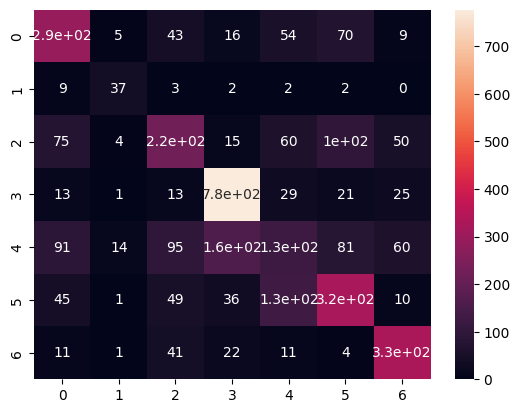

In [28]:
sns.heatmap(cm, annot=True);

In [29]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.55      0.60      0.57       491
           1       0.59      0.67      0.63        55
           2       0.48      0.42      0.45       528
           3       0.76      0.88      0.82       879
           4       0.31      0.20      0.24       626
           5       0.54      0.55      0.54       594
           6       0.68      0.78      0.73       416

    accuracy                           0.59      3589
   macro avg       0.56      0.59      0.57      3589
weighted avg       0.56      0.59      0.57      3589



## Classifying one single image

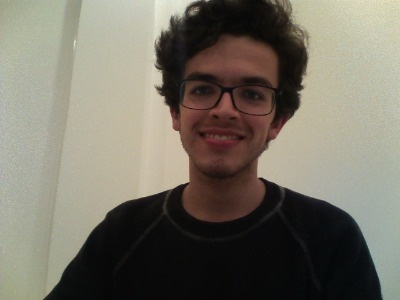

In [30]:
image = cv2.imread('/content/drive/MyDrive/Classification of Emotion/gabriel.png')
cv2_imshow(image)

In [31]:
image.shape

(300, 400, 3)

In [32]:
face_detector = cv2.CascadeClassifier('/content/drive/MyDrive/Classification of Emotion/haarcascade_frontalface_default.xml')

In [33]:
original_image = image.copy()
faces = face_detector.detectMultiScale(original_image)

In [34]:
faces

array([[162,  40, 128, 128]], dtype=int32)

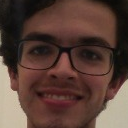

In [35]:
roi = image[40:40 + 128, 162:162 + 128]
cv2_imshow(roi)

In [36]:
roi.shape

(128, 128, 3)

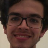

In [37]:
roi = cv2.resize(roi, (48, 48))
cv2_imshow(roi)

In [38]:
roi.shape

(48, 48, 3)

array([[[ 28,  32,  37],
        [ 22,  28,  34],
        [ 33,  37,  42],
        ...,
        [ 12,  16,  17],
        [ 16,  21,  25],
        [ 16,  25,  30]],

       [[ 27,  31,  36],
        [ 31,  36,  41],
        [ 32,  36,  41],
        ...,
        [ 11,  16,  19],
        [ 13,  19,  24],
        [ 17,  25,  28]],

       [[ 27,  31,  36],
        [ 30,  34,  39],
        [ 26,  30,  35],
        ...,
        [ 12,  17,  20],
        [ 14,  20,  25],
        [ 20,  25,  27]],

       ...,

       [[162, 185, 197],
        [166, 188, 200],
        [166, 188, 200],
        ...,
        [162, 181, 188],
        [162, 182, 188],
        [161, 180, 187]],

       [[160, 184, 196],
        [165, 187, 199],
        [166, 188, 200],
        ...,
        [161, 180, 187],
        [162, 181, 187],
        [161, 180, 187]],

       [[160, 184, 196],
        [163, 187, 199],
        [165, 187, 199],
        ...,
        [160, 179, 186],
        [161, 180, 187],
        [162, 181, 188]]], dtype=uint8)
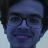

In [39]:
roi

In [40]:
roi = roi / 255
roi

array([[[0.10980392, 0.1254902 , 0.14509804],
        [0.08627451, 0.10980392, 0.13333333],
        [0.12941176, 0.14509804, 0.16470588],
        ...,
        [0.04705882, 0.0627451 , 0.06666667],
        [0.0627451 , 0.08235294, 0.09803922],
        [0.0627451 , 0.09803922, 0.11764706]],

       [[0.10588235, 0.12156863, 0.14117647],
        [0.12156863, 0.14117647, 0.16078431],
        [0.1254902 , 0.14117647, 0.16078431],
        ...,
        [0.04313725, 0.0627451 , 0.0745098 ],
        [0.05098039, 0.0745098 , 0.09411765],
        [0.06666667, 0.09803922, 0.10980392]],

       [[0.10588235, 0.12156863, 0.14117647],
        [0.11764706, 0.13333333, 0.15294118],
        [0.10196078, 0.11764706, 0.1372549 ],
        ...,
        [0.04705882, 0.06666667, 0.07843137],
        [0.05490196, 0.07843137, 0.09803922],
        [0.07843137, 0.09803922, 0.10588235]],

       ...,

       [[0.63529412, 0.7254902 , 0.77254902],
        [0.65098039, 0.7372549 , 0.78431373],
        [0.65098039, 0

In [41]:
roi.shape

(48, 48, 3)

In [42]:
roi = np.expand_dims(roi, axis = 0)
roi.shape

(1, 48, 48, 3)

In [43]:
probs = network_loaded.predict(roi)
probs

1/1 [==============================] - 0s 222ms/step


array([[3.3967436e-04, 9.7660895e-06, 1.3976601e-04, 9.7804397e-01,
        2.0454783e-02, 1.0119140e-03, 3.8935386e-08]], dtype=float32)

In [44]:
result = np.argmax(probs)
result

3

In [45]:
test_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

## Classifying multiple images

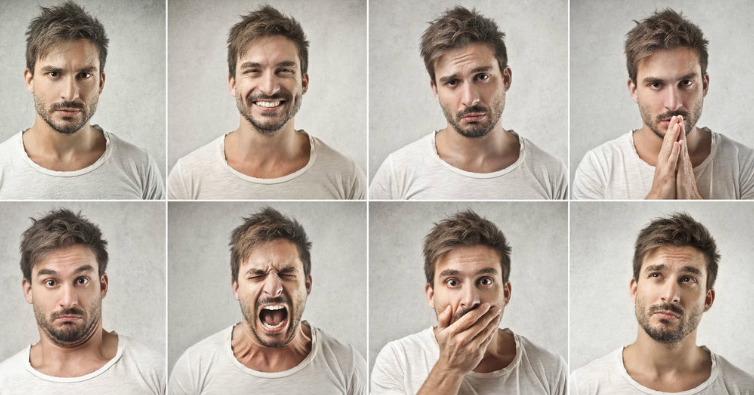

In [46]:
image = cv2.imread('/content/drive/MyDrive/Classification of Emotion/faces_emotions.png')
cv2_imshow(image)

In [47]:
faces = face_detector.detectMultiScale(image)
faces

array([[224,  35,  90,  90],
       [625,  49,  91,  91],
       [ 23,  41,  92,  92],
       [420,  43,  97,  97],
       [420, 242,  97,  97],
       [ 18, 243,  98,  98],
       [229, 242,  85,  85],
       [627, 241,  91,  91]], dtype=int32)

In [48]:
test_dataset.class_indices.keys()

dict_keys(['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])

In [49]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

1/1 [==============================] - 0s 18ms/step


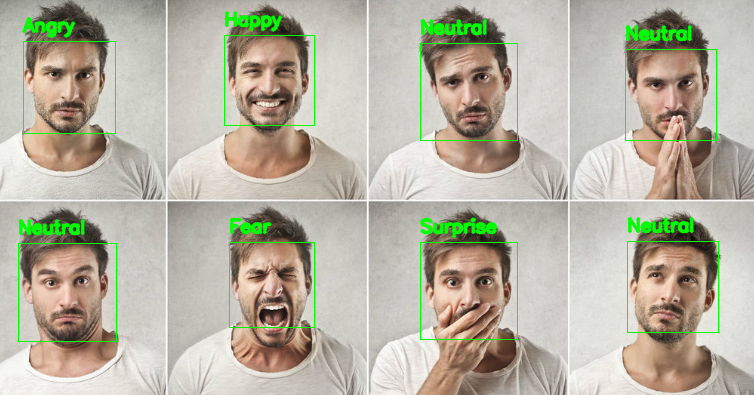

In [50]:
for (x, y, w, h) in faces:
  cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
  roi = image[y:y + h, x:x + w]
  #cv2_imshow(roi)
  roi = cv2.resize(roi, (48, 48))
  #cv2_imshow(roi)
  roi = roi / 255
  roi = np.expand_dims(roi, axis = 0)
  #print(roi.shape)
  prediction = network_loaded.predict(roi)
  #print(prediction)
  cv2.putText(image, emotions[np.argmax(prediction)], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2, cv2.LINE_AA)
cv2_imshow(image)